# Ray HVD TF MNIST

https://docs.ray.io/en/latest/train/examples/tf/tensorflow_mnist_example.html
Modified adding in Horovod.


Using `tensorflow-2.9.0` NERSC kernel.



In [1]:
import sys
import os

In [2]:
# !{sys.executable} -m pip install "ray[air]==2.3.1"

# Start Ray

In [3]:
from ray_utils import start_ray_cluster
ray_cluster = start_ray_cluster()

<> Starting Ray head node


In case of issues, please refer to our known issues: https://docs.nersc.gov/current/
and open a help ticket if your issue is not listed: https://help.nersc.gov/


2023-04-27 11:50:15,738	INFO usage_lib.py:435 -- Usage stats collection is disabled.
2023-04-27 11:50:15,738	INFO scripts.py:710 -- Local node IP: 128.55.66.216
2023-04-27 11:50:17,774	SUCC scripts.py:747 -- --------------------
2023-04-27 11:50:17,774	SUCC scripts.py:748 -- Ray runtime started.
2023-04-27 11:50:17,774	SUCC scripts.py:749 -- --------------------
2023-04-27 11:50:17,774	INFO scripts.py:751 -- Next steps
2023-04-27 11:50:17,774	INFO scripts.py:752 -- To connect to this Ray runtime from another node, run
2023-04-27 11:50:17,774	INFO scripts.py:755 --   ray start --address='128.55.66.216:6379'
2023-04-27 11:50:17,774	INFO scripts.py:771 -- Alternatively, use the following Python code:
2023-04-27 11:50:17,774	INFO scripts.py:773 -- import ray
2023-04-27 11:50:17,774	INFO scripts.py:777 -- ray.init(address='auto')
2023-04-27 11:50:17,774	INFO scripts.py:790 -- To see the status of the cluster, use
2023-04-27 11:50:17,774	INFO scripts.py:791 --   ray status
2023-04-27 11:50:1

In [4]:
ray_cluster.ray.stdout

In [5]:
import ray

if ray.is_initialized:
    ray.shutdown()

ray.init(address='auto')

2023-04-27 11:50:24,807	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 128.55.66.216:6379...
2023-04-27 11:50:24,815	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.15
Ray version:,2.3.1
Dashboard:,http://127.0.0.1:8265


### Check ray cluster resources

In [6]:
ray.cluster_resources()

{'node:128.55.66.216': 1.0,
 'GPU': 4.0,
 'object_store_memory': 74184886272.0,
 'CPU': 128.0,
 'accelerator_type:A100': 1.0,
 'memory': 163098067968.0}

### View dashboards

In [7]:
f'https://jupyter.nersc.gov{os.getenv("JUPYTERHUB_SERVICE_PREFIX")}proxy/localhost:8265/#/new/overview'

'https://jupyter.nersc.gov/user/asnaylor/perlmutter-exclusive-node-gpu/proxy/localhost:8265/#/new/overview'

In [8]:
f'https://jupyter.nersc.gov{os.getenv("JUPYTERHUB_SERVICE_PREFIX")}proxy/3000/d/rayDefaultDashboard'

'https://jupyter.nersc.gov/user/asnaylor/perlmutter-exclusive-node-gpu/proxy/3000/d/rayDefaultDashboard'

# MINST Code

In [9]:
import numpy as np
import json
from ray.air.result import Result
import tensorflow as tf
import horovod.tensorflow.keras as hvd

# from ray.train.tensorflow import TensorflowTrainer
from ray.train.horovod import HorovodTrainer
from ray.air.integrations.keras import Callback as TrainCheckpointReportCallback
from ray.air.config import ScalingConfig, RunConfig
from ray.air import session

In [10]:
def mnist_dataset(batch_size: int) -> tf.data.Dataset:
    (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
    # The `x` arrays are in uint8 and have values in the [0, 255] range.
    # You need to convert them to float32 with values in the [0, 1] range.
    x_train = x_train / np.float32(255)
    y_train = y_train.astype(np.int64)
    train_dataset = (
        tf.data.Dataset.from_tensor_slices((x_train, y_train))
        .shuffle(60000)
        .repeat()
        .batch(batch_size)
    )
    return train_dataset

In [11]:
def build_cnn_model() -> tf.keras.Model:
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(28, 28)),
            tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, 3, activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(10),
        ]
    )
    return model


In [25]:

def train_func(config: dict):
    per_worker_batch_size = config.get("batch_size", 64)
    epochs = config.get("epochs", 3)
    steps_per_epoch = config.get("steps_per_epoch", 70)
    
    # Returns the total number of workers executing training.
    num_workers = session.get_world_size()
    
    # Horovod: initialize library.
    hvd.init()

    # Horovod: pin GPU to be used to process local rank (one GPU per process)
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    if gpus:
        tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()],
                                                   'GPU')
    
    # Horovod: limit # of CPU threads to be used per worker.
    # tf.config.threading.set_intra_op_parallelism_threads(1)
    
    # strategy = tf.distribute.MultiWorkerMirroredStrategy()
    global_batch_size = per_worker_batch_size * num_workers
    multi_worker_dataset = mnist_dataset(global_batch_size)

    # with strategy.scope():
    # Model building/compiling need to be within `strategy.scope()`.
    multi_worker_model = build_cnn_model()

    # Horovod: adjust learning rate based on number of GPUs.
    learning_rate = config.get("lr", 0.001) * hvd.size()

    # Horovod: add Horovod DistributedOptimizer.
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    opt = hvd.DistributedOptimizer(
        opt, backward_passes_per_step=1, average_aggregated_gradients=True)

    # Horovod: Specify `experimental_run_tf_function=False` to ensure TensorFlow
    # uses hvd.DistributedOptimizer() to compute gradients.
    multi_worker_model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=opt,
        metrics=["accuracy"],
        experimental_run_tf_function=False
    )

    callbacks = [
        # Horovod: broadcast initial variable states from rank 0 to all other processes.
        # This is necessary to ensure consistent initialization of all workers when
        # training is started with random weights or restored from a checkpoint.
        hvd.callbacks.BroadcastGlobalVariablesCallback(0),

        # Horovod: average metrics among workers at the end of every epoch.
        #
        # Note: This callback must be in the list before the ReduceLROnPlateau,
        # TensorBoard or other metrics-based callbacks.
        hvd.callbacks.MetricAverageCallback(),

        # Horovod: using `lr = 1.0 * hvd.size()` from the very beginning leads to worse final
        # accuracy. Scale the learning rate `lr = 1.0` ---> `lr = 1.0 * hvd.size()` during
        # the first three epochs. See https://arxiv.org/abs/1706.02677 for details.
        hvd.callbacks.LearningRateWarmupCallback(initial_lr=learning_rate, warmup_epochs=3, verbose=1),
    ]
    
    # Horovod: save checkpoints only on worker 0 to prevent other workers from corrupting them.
    # if hvd.rank() == 0:
        # callbacks.append(tf.keras.callbacks.ModelCheckpoint('./checkpoint-{epoch}.h5'))
    callbacks.append(TrainCheckpointReportCallback())
    
    # Horovod: write logs on worker 0.
    verbose = 1 if hvd.rank() == 0 else 0

    history = multi_worker_model.fit(
        multi_worker_dataset,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        verbose=verbose
    )
    # Horovod: adjust number of steps based on number of GPUs. ??
    # steps_per_epoch=500 // hvd.size(),
    results = history.history
    return results

# Run MNIST Code

In [26]:
args = {
    'num_workers': int(ray.cluster_resources()['GPU']),
    'use_gpu': True,
    'epochs': 10
}
config = {"lr": 1e-3, "batch_size": 64, "epochs": args['epochs']}

In [27]:
trainer = HorovodTrainer(
    train_loop_per_worker=train_func,
    train_loop_config=config,
    scaling_config=ScalingConfig(num_workers=args['num_workers'], use_gpu=args['use_gpu']),
    run_config=RunConfig(local_dir=f'{os.getenv("SCRATCH")}/ray_results', name='HVD_TF_MNIST')
)
results =  trainer.fit()


2023-04-27 12:14:44,815	WARNING trial_runner.py:369 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (140 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent trials.
(RayTrainWorker pid=64058) 2023-04-27 12:14:53.952054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
(RayTrainWorker pid=64058) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(RayTrainWorker pid=64054) 2023-04-27 12:14:53.937038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Ne

(RayTrainWorker pid=64054) Epoch 1/10


(RayTrainWorker pid=64054) 2023-04-27 12:14:57.392178: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
(RayTrainWorker pid=64060) 2023-04-27 12:14:57.405504: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
(RayTrainWorker pid=64058) 2023-04-27 12:14:57.526853: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
(RayTrainWorker pid=64059) 2023-04-27 12:14:57.513112: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
(RayTrainWorker pid=64054) 2023-04-27 12:14:58.095025: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
(RayTrainWorker pid=64060) 2023-04-27 12:14:58.116066: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
(RayTrainWorker pid=64058) 2023-04-27 12:14:58.239917: I tensorflow/stream_e

66/70 [===========================>..] - ETA: 0s - loss: 2.2796 - accuracy: 0.1382


Trial name,_time_this_iter_s,_timestamp,_training_iteration,accuracy,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,loss,lr,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
HorovodTrainer_c4e81_00000,0.432108,1682622903,10,0.888128,2023-04-27_12-15-03,True,,5e079979573348f6b3c286ab0686f34e,0,nid003732,10,0.41328,0.004,128.55.66.216,62304,True,15.3555,0.43297,15.3555,1682622903,0,,10,c4e81_00000,0.0608425


70/70 [==============================] - 5s 6ms/step - loss: 2.2788 - accuracy: 0.1438 - lr: 0.0020
(RayTrainWorker pid=64054) Epoch 2/10
70/70 [==============================] - 0s 7ms/step - loss: 2.1844 - accuracy: 0.4468 - lr: 0.0030
(RayTrainWorker pid=64054) Epoch 3/10
61/70 [=========================>....] - ETA: 0s - loss: 1.9558 - accuracy: 0.7049
(RayTrainWorker pid=64054) Epoch 3: finished gradual learning rate warmup to 0.004.
70/70 [==============================] - 0s 7ms/step - loss: 1.9260 - accuracy: 0.7093 - lr: 0.0040
(RayTrainWorker pid=64054) Epoch 4/10
70/70 [==============================] - 0s 6ms/step - loss: 1.3514 - accuracy: 0.7891 - lr: 0.0040
(RayTrainWorker pid=64054) Epoch 5/10
70/70 [==============================] - 0s 6ms/step - loss: 0.8643 - accuracy: 0.8299 - lr: 0.0040
(RayTrainWorker pid=64054) Epoch 6/10
70/70 [==============================] - 0s 6ms/step - loss: 0.6401 - accuracy: 0.8528 - lr: 0.0040
(RayTrainWorker pid=64054) Epoch 7/10
70/70

2023-04-27 12:15:06,217	INFO tune.py:798 -- Total run time: 21.41 seconds (21.39 seconds for the tuning loop).


In [29]:
results

Result(metrics={'loss': 0.4132797, 'accuracy': 0.88812774, 'lr': 0.004, '_timestamp': 1682622903, '_time_this_iter_s': 0.43210816383361816, '_training_iteration': 10, 'should_checkpoint': True, 'done': True, 'trial_id': 'c4e81_00000', 'experiment_tag': '0'}, error=None, log_dir=PosixPath('/pscratch/sd/a/asnaylor/ray_results/HVD_TF_MNIST/HorovodTrainer_c4e81_00000_0_2023-04-27_12-14-44'))

<AxesSubplot: xlabel='training_iteration'>

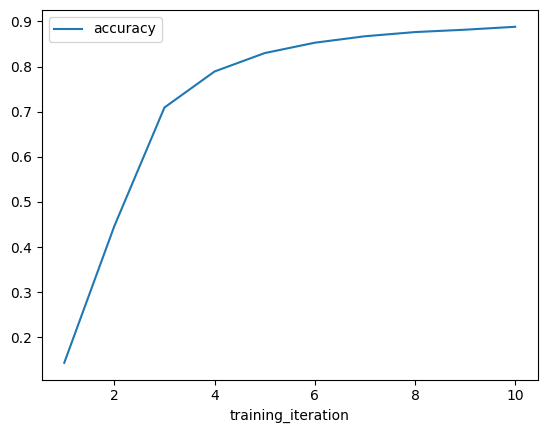

In [30]:
results.metrics_dataframe.plot("training_iteration", "accuracy")

In [31]:
# results.metrics_dataframe
results.checkpoint

TensorflowCheckpoint(local_path=/pscratch/sd/a/asnaylor/ray_results/HVD_TF_MNIST/HorovodTrainer_c4e81_00000_0_2023-04-27_12-14-44/checkpoint_000009)

In [32]:
from ray.train.tensorflow import TensorflowCheckpoint, TensorflowPredictor
from ray.train.batch_predictor import BatchPredictor

result_checkpoint: TensorflowCheckpoint = results.checkpoint
predictor = TensorflowPredictor.from_checkpoint(
    result_checkpoint, model_definition=build_cnn_model
)

2023-04-27 12:15:28.987645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 12:15:30.787807: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2023-04-27 12:15:30.789537: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38218 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-04-27 12:15:30.791035: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

In [33]:
_, (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# The `x` arrays are in uint8 and have values in the [0, 255] range.
# You need to convert them to float32 with values in the [0, 1] range.
x_test = x_test / np.float32(255)
y_test = y_test.astype(np.int64)

2023-04-27 12:15:32.898983: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302


Predicted Class = 2


2023-04-27 12:15:33.591969: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


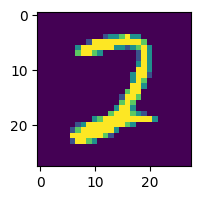

In [34]:
import matplotlib.pyplot as plt
from random import randint

img_num = randint(0, len(x_test))
test_img = x_test[img_num:img_num+1,:,:]
plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape((28, 28)))

predicted_class = np.argmax(predictor.predict(test_img)['predictions'])
print("Predicted Class =", predicted_class)

### Shutdown

In [35]:
ray.shutdown()

In [36]:
ray_cluster.kill()